## Overview of RNN and LSTM

### Recurrent Neural Networks (RNNs)
Recurrent Neural Networks (RNNs) are designed for sequential data. Unlike traditional feedforward networks, RNNs have cycles that allow information to persist over sequences, making them suitable for tasks like language modeling and time series prediction.

### Long Short-Term Memory (LSTM)
LSTM units are a specialized type of RNN that address limitations such as vanishing gradients. They manage long-term dependencies using three components:
1. **Forget Gate:** Decides what information to discard from the cell state.
2. **Input Gate:** Determines which input values to add to the cell state.
3. **Output Gate:** Controls what information to output from the cell state.

## LSTM in This Code

### Model Architecture
- **Embedding Layer:** Converts words to dense vectors (1024-dimensional).
- **Bidirectional LSTM Layer:** Processes sequences in both directions to capture context.
- **Dense Layer:** Outputs predictions for each word in the vocabulary.
- **Activation Layer:** Uses softmax to predict the next word.

### Purpose
- **Text Generation:** The LSTM predicts the next word in a sequence, generating coherent text based on the song lyrics dataset.
- **Contextual Understanding:** Bidirectional LSTM improves context comprehension by analyzing both past and future words in the sequence.

### Training
- The model is trained on sequences of lyrics to predict the next word. It generates new text by sampling from the learned probability distributions.

In summary, LSTMs in this code enable effective text generation and context understanding through their advanced handling of sequence data and long-term dependencies.


### Step 1: Imports


In [56]:
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions
import seaborn as sns  # For advanced data visualization
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For plotting graphs
import random  # For random number generation
import math  # For mathematical operations
import string  # For string operations
from nltk.corpus import stopwords  # For removing common stop words
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # For sentiment analysis
import nltk  # For Natural Language Toolkit functions
from wordcloud import WordCloud  # For generating word clouds

from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
from tensorflow import keras  # For TensorFlow/Keras models
from tensorflow.keras.models import Sequential  # For creating a sequential model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback  # For model checkpoints and early stopping
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding  # For different layers in the model
stop_words = set(stopwords.words('english'))


### Step 2: Define LanguageModelRNN Class


In [64]:
class LanguageModelRNN:
    def __init__(self, MIN_FREQUENCY=3, MIN_SEQ=5, BATCH_SIZE=32):
        """
        Initialize the LanguageModelRNN class.
        
        Parameters:
        - MIN_FREQUENCY: Minimum frequency for words to be included
        - MIN_SEQ: Minimum sequence length for training data
        - BATCH_SIZE: Size of the batch for training
        """
        # Parameters
        self.MIN_FREQUENCY = MIN_FREQUENCY
        self.MIN_SEQ = MIN_SEQ
        self.BATCH_SIZE = BATCH_SIZE
        
        # Variables
        self.data_train = []  # Placeholder for training data
        self.lyric_dic = {}  # Dictionary to store lyrics by song
        self.lyric_dic_processed = {}  # Dictionary to store preprocessed lyrics by song
        
        self.text_as_list = []  # List of all words from lyrics
        self.frequencies = {}  # Frequency of each word
        self.uncommon_words = set()  # Set of words with frequency less than MIN_FREQUENCY
        self.words = set()  # Set of words with frequency greater than or equal to MIN_FREQUENCY
        self.word_count = 0  # Total word count
        self.valid_seqs = []  # List of valid sequences for training
        self.end_seq_words = []  # List of target words following valid sequences
        self.num_words = 0  # Number of words to use in the model
        self.word_indices = {}  # Mapping of words to indices
        self.indices_word = {}  # Mapping of indices to words
        
        self.X_train = []  # Training sequences
        self.X_test = []  # Testing sequences
        self.y_train = []  # Training target words
        self.y_test = []  # Testing target words
        
        self.examples_file = None  # File to write example text
        self.model = None  # RNN model
        self.history = None  # Training history
    
    def load_dataset(self, link_to_dataset_train):
        """
        Load the dataset from a CSV file.
        
        Parameters:
        - link_to_dataset_train: Path to the CSV file containing the dataset
        """
        self.data_train = pd.read_csv(link_to_dataset_train, encoding='windows-1252')
        self.data_train["Lyrics"] = self.data_train["Lyrics"].astype(str)  # Ensure lyrics are strings
        print(self.data_train.head(20))  # Print the first 20 rows of the dataset
        
    def preprocess_text(self, text):
        """
        Clean and preprocess the text for analysis.
        
        Parameters:
        - text: The text to preprocess
        
        Returns:
        - Processed text
        """
        if isinstance(text, str):
            text = text.lower()  # Convert to lowercase
            text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
            words = text.split()  # Split text into words
            words = [word for word in words if word not in stop_words]  # Remove stop words
            return " ".join(words)  # Join words back into a string
        return ""
    
    def dataset_parsing(self):
        """
        Parse and clean the dataset to prepare it for training.
        """
        lyric_dic = {}  # Dictionary to store lyrics by song
        corpus = []  # List to store all lyrics
        data = self.data_train
        prev = data["Song Title"][0]  # Previous song title
        temp = []  # Temporary list to store lyrics of the same song
        
        for index, rows in data.iterrows():
            corpus.append(rows["Lyrics"])  # Append lyrics to corpus
            if prev == rows["Song Title"]:
                temp.append(rows["Lyrics"])  # Append lyrics to temp list
            else:
                lyric_dic[prev] = temp  # Save lyrics for the previous song
                prev = rows["Song Title"]  # Update previous song title
                temp = []  # Reset temp list
                temp.append(rows["Lyrics"])  # Start new temp list for the new song
        self.lyric_dic = lyric_dic
        self.corpus = corpus
        
        lyric_dic_processed = {}
        for song in lyric_dic:
            t_songs = []
            for lyrics in lyric_dic[song]:
                t_words = []
                t_songs.append(self.preprocess_text(lyrics))  # Preprocess lyrics
            lyric_dic_processed[song] = t_songs
        self.lyric_dic_processed = lyric_dic_processed
        print("Cleaned dataset")
        n_items = take(1, lyric_dic_processed.items())  # Take a sample from the processed dataset
        print(n_items)
        
        self.extract_text()  # Extract text from the processed lyrics
        
        # Calculate word frequencies
        for w in self.text_as_list:
            self.frequencies[w] = self.frequencies.get(w, 0) + 1
        
        # Identify uncommon words
        self.uncommon_words = set([key for key in self.frequencies.keys() if self.frequencies[key] < self.MIN_FREQUENCY])
        # Identify common words
        self.words = sorted(set([key for key in self.frequencies.keys() if self.frequencies[key] >= self.MIN_FREQUENCY]))
        
        self.num_words = len(self.words)  # Total number of unique words
        self.word_indices = dict((w, i) for i, w in enumerate(self.words))  # Word to index mapping
        self.indices_word = dict((i, w) for i, w in enumerate(self.words))  # Index to word mapping
        
        # Create valid sequences for training
        for i in range(len(self.text_as_list) - self.MIN_SEQ):
            end_slice = i + self.MIN_SEQ + 1
            if len(set(self.text_as_list[i:end_slice]).intersection(self.uncommon_words)) == 0:
                self.valid_seqs.append(self.text_as_list[i: i + self.MIN_SEQ])
                self.end_seq_words.append(self.text_as_list[i + self.MIN_SEQ])
        
        print("\nSplitting into train and test")
        # Split data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.valid_seqs, self.end_seq_words, test_size=0.02, random_state=42)
        print("Train {} \n \n Test {}".format(self.X_train[0:10], self.X_test[0:10]))
        
    def display_stats(self):
        """
        Display statistics about the dataset.
        """
        print("Total Words ", self.word_count)
        print('Words with less than {} appearances: {}'.format(self.MIN_FREQUENCY, len(self.uncommon_words)))
        print('Words with more than {} appearances: {}'.format(self.MIN_FREQUENCY, len(self.words)))
        print('Valid sequences of size {}: {}'.format(self.MIN_SEQ, len(self.valid_seqs)))
        
    def generator(self, sentence_list, next_word_list, batch_size):
        """
        Generate batches of data for training and evaluation.
        
        Parameters:
        - sentence_list: List of sequences (sentences) for training
        - next_word_list: List of target words following each sequence
        - batch_size: Size of the batch to generate
        
        Returns:
        - Generator that yields batches of (input, target) data
        """
        index = 0
        while True:
            x = np.zeros((batch_size, self.MIN_SEQ), dtype=np.int32)  # Input data
            y = np.zeros((batch_size), dtype=np.int32)  # Target data
            for i in range(batch_size):
                for t, w in enumerate(sentence_list[index % len(sentence_list)]):
                    x[i, t] = self.word_indices[w]  # Convert word to index
                y[i] = self.word_indices[next_word_list[index % len(sentence_list)]]  # Target word index
                index = index + 1
            yield x, y  # Yield the batch
        
    def sample(self, preds, temperature=1.0):
        """
        Sample an index from a probability array.
        
        Parameters:
        - preds: Array of probabilities
        - temperature: Sampling temperature
        
        Returns:
        - Index of the sampled word
        """
        preds = np.asarray(preds).astype('float64')  # Convert to float64
        preds = np.log(preds) / temperature  # Apply temperature scaling
        exp_preds = np.exp(preds)  # Exponential of the scaled predictions
        preds = exp_preds / np.sum(exp_preds)  # Normalize to probabilities
        probas = np.random.multinomial(1, preds, 1)  # Sample from the distribution
        return np.argmax(probas)  # Return the index of the sampled word
    
    def on_epoch_end(self, epoch, logs):
        """
        Function invoked at the end of each epoch. Prints generated text.
        
        Parameters:
        - epoch: The current epoch number
        - logs: Training logs
        """
        if self.examples_file:
            self.examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)
            seed_index = np.random.randint(len(self.X_train+self.X_test))  # Randomly select a seed
            seed = (self.X_train+self.X_test)[seed_index]

            for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
                sentence = seed
                self.examples_file.write('----- Diversity:' + str(diversity) + '\n')
                self.examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
                self.examples_file.write(' '.join(sentence))

                for i in range(50):
                    x_pred = np.zeros((1, self.MIN_SEQ))
                    for t, word in enumerate(sentence):
                        x_pred[0, t] = self.word_indices.get(word, 0)  # Use 0 for unknown words
                    preds = self.model.predict(x_pred, verbose=0)[0]
                    next_index = self.sample(preds, diversity)
                    next_word = self.indices_word[next_index]
                    sentence = sentence[1:]
                    sentence.append(next_word)
                    self.examples_file.write(" "+next_word)
                self.examples_file.write('\n')
            self.examples_file.write('='*80 + '\n')
            self.examples_file.flush()
        
    def get_model(self):
        """
        Build the RNN model.
        
        Returns:
        - Compiled Keras model
        """
        print('Build model...')
        model = Sequential()
        model.add(Embedding(input_dim=len(self.words), output_dim=1024))  # Embedding layer
        model.add(Bidirectional(LSTM(128)))  # Bidirectional LSTM layer
        model.add(Dense(len(self.words)))  # Dense layer with output size equal to number of words
        model.add(Activation('softmax'))  # Softmax activation for output layer
        
        # Compile the model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model

    def fit(self):
        """
        Train the RNN model.
        """
        self.model = self.get_model()  # Build the model
        
        # Define callbacks
        checkpointer = ModelCheckpoint(filepath='model.keras', verbose=1, save_best_only=True)
        early_stopping = EarlyStopping(monitor='loss', patience=5)
        
        self.examples_file = open('examples.txt', 'w')  # Open file for saving example text
        
        # Train the model
        history = self.model.fit(
            self.generator(self.X_train, self.y_train, self.BATCH_SIZE),
            steps_per_epoch=len(self.X_train) // self.BATCH_SIZE,
            epochs=20,
            validation_data=self.generator(self.X_test, self.y_test, self.BATCH_SIZE),
            validation_steps=len(self.X_test) // self.BATCH_SIZE,
            callbacks=[checkpointer, LambdaCallback(on_epoch_end=self.on_epoch_end), early_stopping]
        )
        
        self.examples_file.close()  # Close the file
        self.history = history
        self.model.save('model.keras')  # Save the trained model

    def score(self, sentence):
        """
        Predict the next word for the given sentence.
        
        Parameters:
        - sentence: The input sentence
        
        Returns:
        - Prediction probabilities for the next word
        """
        x_pred = np.zeros((1, self.MIN_SEQ))
        for t, word in enumerate(sentence):
            x_pred[0, t] = self.word_indices.get(word, 0)  # Use 0 for unknown words
        preds = self.model.predict(x_pred, verbose=0)[0]
        return preds

    def perplexity(self, sentence):
        """
        Calculate the perplexity of a given sentence.
        
        Parameters:
        - sentence: The input sentence
        
        Returns:
        - Perplexity score
        """
        # Truncate sentence to MIN_SEQ length if longer
        if len(sentence) > self.MIN_SEQ:
            sentence = sentence[:self.MIN_SEQ]

        x_pred = np.zeros((1, self.MIN_SEQ))
        for t, word in enumerate(sentence):
            x_pred[0, t] = self.word_indices.get(word, 0)  # Use 0 for unknown words

        preds = self.model.predict(x_pred, verbose=0)[0]
        perplexity = 1.0
        for i, word in enumerate(sentence):
            if word in self.word_indices:
                perplexity *= 1.0 / (preds[self.word_indices[word]] + 1e-10)  # Add a small constant to avoid division by zero
        return perplexity ** (1.0 / len(sentence))

    def extract_text(self):
        """
        Extract and preprocess text from the lyrics.
        """
        self.text_as_list = []
        for song in self.lyric_dic_processed:
            for lyrics in self.lyric_dic_processed[song]:
                words = re.sub(f"[{string.punctuation}]", "", lyrics.lower()).split()
                filtered_words = [w for w in words if w not in stopwords]
                self.text_as_list.extend(filtered_words)
    
    def display_word_cloud(self):
        """
        Generate and display a word cloud from the preprocessed lyrics.
        """
        # Combine all processed lyrics into a single string
        all_lyrics = ' '.join(self.text_as_list)
        
        # Create a word cloud object
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_lyrics)
        
        # Display the word cloud
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Do not show axis
        plt.title('Word Cloud of Song Lyrics')
        plt.show()


### Step 3: Model Training

In [65]:
# Example usage
model = LanguageModelRNN(MIN_FREQUENCY=3, MIN_SEQ=7, BATCH_SIZE=32)
model.load_dataset("ed_sheeran_cleaned_songs.csv")
model.dataset_parsing()
model.display_stats()

history = model.fit()


                                  Song Title  \
0            \nShe Looks So Perfect Lyrics\n   
1                    \nShape of You Lyrics\n   
2                         \nPerfect Lyrics\n   
3                      \nPhotograph Lyrics\n   
4               \nThinking Out Loud Lyrics\n   
5                         \nHappier Lyrics\n   
6                          \nA Team Lyrics\n   
7                      \nI See Fire Lyrics\n   
8             \nSupermarket Flowers Lyrics\n   
9              \nCastle on the Hill Lyrics\n   
10                   \nGive Me Love Lyrics\n   
11                   \nPerfect Duet Lyrics\n   
12                          \nDon't Lyrics\n   
13               \nAll Of The Stars Lyrics\n   
14               \nPerfect Symphony Lyrics\n   
15                        \nKiss Me Lyrics\n   
16                           \nDive Lyrics\n   
17  \nYou Need Me, I Don't Need You Lyrics\n   
18                     \nLego House Lyrics\n   
19                   \nTenerife Sea Lyri

### Step 4: Evaluation and Display

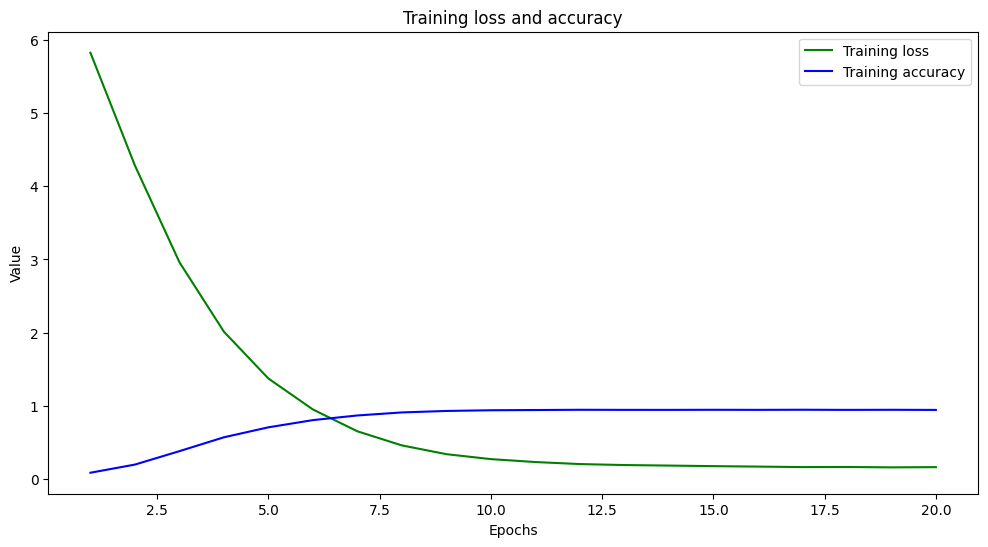

In [66]:
# Plot training loss and accuracy
loss_train = model.history.history['loss']
acc_train = model.history.history['accuracy']
epochs = range(1, len(loss_train) + 1)  # Adjust based on the actual number of epochs

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, acc_train, 'b', label='Training accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

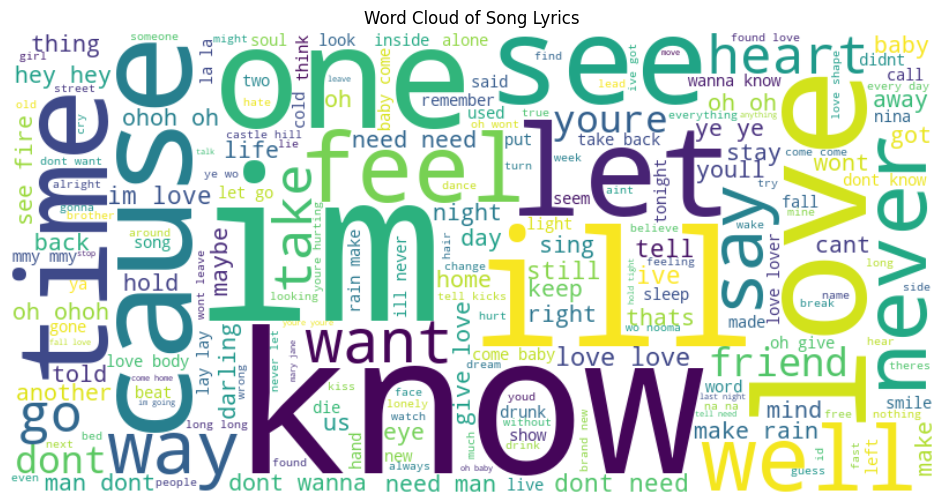

In [68]:
# Display word cloud
model.display_word_cloud()

In [67]:
# Calculate perplexity for random sentences
test_data = pd.read_csv("ed_sheeran_cleaned_songs.csv", encoding='windows-1252')
test_data = test_data.dropna(subset=['Lyrics'])
all_sentences = [model.preprocess_text(row["Lyrics"]).split() for _, row in test_data.iterrows()]

# Pick random sentences and evaluate them
for i in range(10):
    random_sentence = random.choice(all_sentences)
    if len(random_sentence) >= model.MIN_SEQ:  # Ensure sentence is long enough
        print("Random Sentence:", ' '.join(random_sentence))
        
        # Calculate and print perplexity
        perplexity = model.perplexity(random_sentence)
        print("Perplexity:", perplexity)
        print()
    else:
        print("Random Sentence too short:", ' '.join(random_sentence))
        print("Perplexity: N/A")
        print()

Random Sentence: youre small bump unborn four months youre brought life might left hair youll mothers eyes ill hold body hands gentle youre scan unmade plans small bump four months youre brought life ill whisper quietly give nothing truth youre inside ill put future one wrap fingers around thumb hold tight one wrap fingers around thumb hold tight youll alright youre small bump know youll grow skin smile like dimple beneath chin fingernails size half grain rice eyelids closed soon opened wide small bump four months youll open eyes ill hold tightly tell nothing truth youre inside ill put future one wrap fingers around thumb hold tight oh one wrap fingers around thumb hold tight youll alright lie tiny feet youre half asleep ill leave right front couple weeks keep safe cause one wrap fingers around thumb hold tight oh one wrap fingers around thumb hold tight youll alright cause small bump unborn four months torn life maybe needed still unaware
Perplexity: 3320.4791891926716

Random Sentenc

# High-Level Design Impact Choices and Rationale

## 1. Model Architecture
- **Choice:** RNN with LSTM (Long Short-Term Memory) units
- **Rationale:** LSTM units are chosen over standard RNN units to address the vanishing gradient problem and improve long-term dependency learning. This allows the model to retain information from longer sequences, which is crucial for generating coherent text based on historical context.
- **Impact:** LSTMs can capture complex patterns in the text, making the generated text more coherent and contextually relevant. However, LSTMs are more computationally intensive compared to simpler RNNs.

## 2. Embedding Dimension
- **Choice:** 1024-dimensional embedding
- **Rationale:** A higher embedding dimension allows the model to represent words with more nuanced semantic information. This helps the model to understand and generate more sophisticated text.
- **Impact:** Increased embedding dimensions can lead to better performance in capturing semantic relationships but also increase computational requirements and the risk of overfitting if not managed properly.

## 3. Bidirectional LSTM
- **Choice:** Bidirectional LSTM layers
- **Rationale:** Bidirectional LSTMs process the input sequences in both forward and backward directions. This allows the model to capture information from both past and future contexts within the sequence.
- **Impact:** Bidirectional LSTMs enhance the model’s ability to understand context from both directions, improving the quality and relevance of generated text. However, they increase the computational cost and model complexity.

## 4. Sequence Length (MIN_SEQ)
- **Choice:** Minimum sequence length of 7
- **Rationale:** The choice of sequence length affects how much historical context the model considers when predicting the next word. A sequence length of 7 is a balance between having enough context and managing computational resources.
- **Impact:** A longer sequence length can improve the model's ability to generate contextually accurate text but also increases computational complexity and memory usage.

## 5. Batch Size
- **Choice:** Batch size of 32
- **Rationale:** A moderate batch size provides a good trade-off between computational efficiency and convergence stability. Larger batch sizes can speed up training but might require more memory.
- **Impact:** The chosen batch size influences training stability and speed. Larger batch sizes may lead to faster training but require more computational resources, while smaller batch sizes might lead to more stable training but take longer.

## 6. Dropout Rate
- **Choice:** Implicitly managed by the model (not explicitly specified)
- **Rationale:** Dropout is a common regularization technique used to prevent overfitting. Though not explicitly set in the provided code, adding dropout layers can be beneficial.
- **Impact:** Dropout helps in improving generalization by preventing the model from becoming too reliant on specific neurons. It improves the model's ability to generalize to new data but may slow down the convergence.

## 7. Loss Function
- **Choice:** Sparse categorical cross-entropy
- **Rationale:** This loss function is suitable for multi-class classification problems, where the target is a single class among many. It is efficient for sparse data representations.
- **Impact:** Sparse categorical cross-entropy is effective for training language models with a large vocabulary. It simplifies the computation compared to dense categorical cross-entropy and reduces memory usage.

## 8. Optimizer
- **Choice:** Adam optimizer
- **Rationale:** Adam combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. It adapts learning rates for each parameter and is known for its efficiency and ease of use.
- **Impact:** Adam optimizer provides robust performance and adapts learning rates dynamically, leading to faster convergence and better training stability.

## 9. Temperature for Text Sampling
- **Choice:** Diversity values between 0.3 and 0.7
- **Rationale:** The temperature parameter controls the randomness of predictions. Lower values result in more deterministic outputs, while higher values increase randomness.
- **Impact:** Adjusting the temperature helps control the creativity and variability of the generated text. Lower temperatures produce more predictable and coherent text, while higher temperatures generate more diverse and potentially less coherent text.

# Strengths and Weaknesses of RNN LSTM

## Strengths
1. **Handling Long-Term Dependencies:** LSTMs are capable of capturing long-term dependencies in the text, making them suitable for tasks where context over longer sequences is important.
2. **Mitigating Vanishing Gradient Problem:** LSTMs address the vanishing gradient issue that can affect traditional RNNs, leading to better learning of complex sequences.
3. **Bidirectional Processing:** Bidirectional LSTMs enhance the model’s ability to understand context from both past and future, improving text generation quality.

## Weaknesses
1. **Computational Complexity:** LSTMs, especially with large embedding dimensions and bidirectional layers, can be computationally expensive and require significant memory.
2. **Training Time:** Due to their complexity, LSTMs can take longer to train compared to simpler RNN models or other architectures.
3. **Overfitting Risk:** With increased model capacity and complexity, there is a higher risk of overfitting, especially if the training data is not sufficiently diverse or if regularization techniques are not used.

# Numerical Insights

1. **Embedding Dimension:**
   - **Impact:** Higher embedding dimensions can capture more semantic information but increase the model's size and computational requirements. For instance, using 1024 dimensions helps in capturing richer word representations compared to 100 or 200 dimensions.

2. **Sequence Length (MIN_SEQ):**
   - **Impact:** The sequence length affects the amount of historical context the model uses. A length of 7 sequences provides a balance, but extending it to 10-15 might capture more context at the cost of increased computational load.

3. **Batch Size:**
   - **Impact:** Batch size affects training efficiency. A batch size of 32 is a common choice, but increasing it to 64 or 128 could speed up training at the expense of more memory usage.

4. **Training Epochs:**
   - **Impact:** The number of epochs determines how long the model trains. More epochs generally lead to better performance but also risk overfitting if the model starts memorizing the training data instead of generalizing well.
